# Decision Trees vs Random Forests (with Preprocessing)

This notebook demonstrates a complete, reproducible workflow:
- Load a dataset (Breast Cancer Wisconsin, from `sklearn.datasets`)
- Train/test split
- Preprocess (impute missing values, even if none are present)
- Train a **DecisionTreeClassifier** and a **RandomForestClassifier**
- Hyperparameter tuning with **GridSearchCV**
- Compare metrics: Accuracy, Precision, Recall, F1, Confusion Matrix
- Cross-validation comparison
- Inspect feature importances
- Visualize a fitted Decision Tree


In [3]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

# Imports
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [5]:

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Basic EDA peek
print("Shape:", X.shape)
print("Classes:", dict(zip(data.target_names, np.bincount(y))))
X.head()


Shape: (569, 30)
Classes: {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:

# Identify numeric columns (all are numeric in this dataset)
numeric_features = X.columns.tolist()

# Preprocess: SimpleImputer(strategy="median") – robust to outliers
preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
    ],
    remainder="drop",
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(426, 30) (143, 30) (426,) (143,)


In [7]:

# Decision Tree pipeline + small hyperparameter grid
dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

dt_param_grid = {
    "clf__max_depth": [None, 3, 5, 10],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__criterion": ["gini", "entropy"]
}

dt_grid = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=0
)
dt_grid.fit(X_train, y_train)

print("Best Decision Tree Params:", dt_grid.best_params_)
print("Best CV Accuracy (DT):", dt_grid.best_score_)

# Evaluate on test set
dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)

print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, target_names=data.target_names))
print("Confusion Matrix (DT):\n", confusion_matrix(y_test, y_pred_dt))


Best Decision Tree Params: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV Accuracy (DT): 0.9577838577291382
Decision Tree Test Accuracy: 0.9300699300699301
              precision    recall  f1-score   support

   malignant       0.88      0.94      0.91        53
      benign       0.97      0.92      0.94        90

    accuracy                           0.93       143
   macro avg       0.92      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143

Confusion Matrix (DT):
 [[50  3]
 [ 7 83]]


In [8]:

# Random Forest pipeline + small hyperparameter grid
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=200))
])

rf_param_grid = {
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=0
)
rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Best CV Accuracy (RF):", rf_grid.best_score_)

# Evaluate on test set
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)

print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=data.target_names))
print("Confusion Matrix (RF):\n", confusion_matrix(y_test, y_pred_rf))


Best Random Forest Params: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best CV Accuracy (RF): 0.9624076607387142
Random Forest Test Accuracy: 0.958041958041958
              precision    recall  f1-score   support

   malignant       0.96      0.92      0.94        53
      benign       0.96      0.98      0.97        90

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143

Confusion Matrix (RF):
 [[49  4]
 [ 2 88]]


In [9]:

# Cross-validation comparison on the whole dataset using the best params (refit on full data inside CV)
dt_best_params = dt_grid.best_params_
rf_best_params = rf_grid.best_params_

# Build fresh pipelines with best params
dt_final = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=dt_best_params["clf__max_depth"],
        min_samples_split=dt_best_params["clf__min_samples_split"],
        min_samples_leaf=dt_best_params["clf__min_samples_leaf"],
        criterion=dt_best_params["clf__criterion"],
    ))
])

rf_final = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=200,
        max_depth=rf_best_params["clf__max_depth"],
        min_samples_split=rf_best_params["clf__min_samples_split"],
        min_samples_leaf=rf_best_params["clf__min_samples_leaf"],
        max_features=rf_best_params["clf__max_features"],
    ))
])

dt_scores = cross_val_score(dt_final, X, y, cv=5, scoring="accuracy", n_jobs=-1)
rf_scores = cross_val_score(rf_final, X, y, cv=5, scoring="accuracy", n_jobs=-1)

print("DT CV Accuracy (mean ± std): {:.4f} ± {:.4f}".format(dt_scores.mean(), dt_scores.std()))
print("RF CV Accuracy (mean ± std): {:.4f} ± {:.4f}".format(rf_scores.mean(), rf_scores.std()))


DT CV Accuracy (mean ± std): 0.9367 ± 0.0101
RF CV Accuracy (mean ± std): 0.9649 ± 0.0184


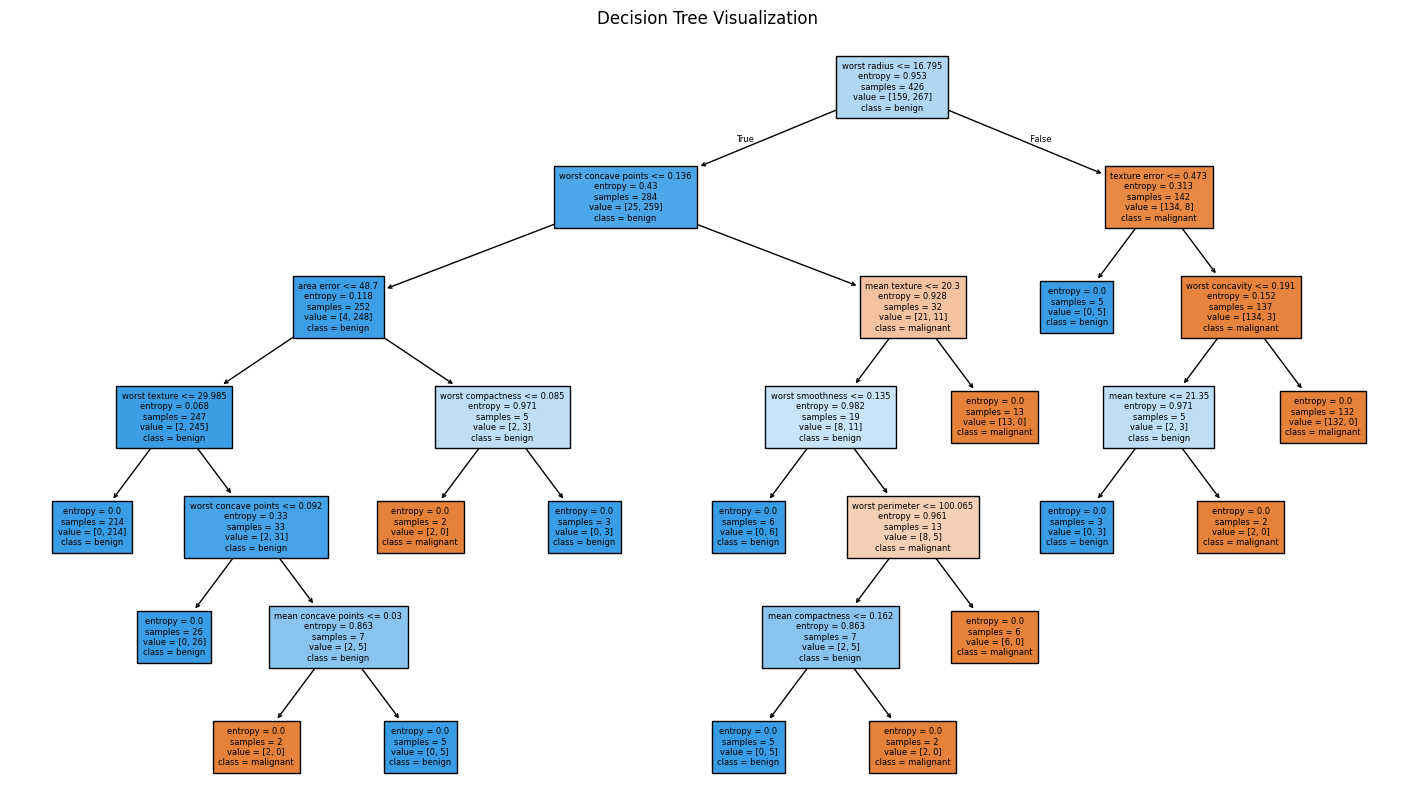

In [10]:

# Visualize the trained decision tree (from dt_best) using matplotlib
# Note: plot_tree works without Graphviz.
plt.figure(figsize=(18, 10))
# Access the inner DecisionTreeClassifier
inner_dt = dt_best.named_steps["clf"]
# After preprocessing, feature names remain numeric order; we can pass X.columns as a proxy
plot_tree(inner_dt, filled=True, feature_names=list(X.columns), class_names=list(data.target_names), fontsize=6)
plt.title("Decision Tree Visualization")
plt.show()


worst perimeter         0.136374
worst area              0.116220
worst concave points    0.094404
worst radius            0.087694
mean concave points     0.085172
mean perimeter          0.065512
mean concavity          0.059324
mean radius             0.053281
mean area               0.051898
area error              0.036080
dtype: float64


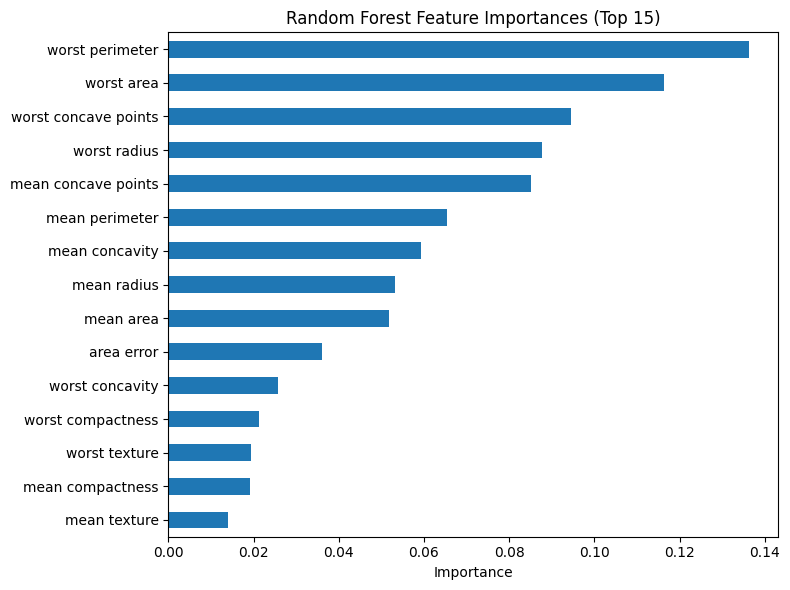

In [11]:

# Feature importances from the Random Forest
inner_rf = rf_best.named_steps["clf"]
importances = inner_rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print(feat_imp.head(10))

# Plot top 15 importances
plt.figure(figsize=(8, 6))
feat_imp.head(15).iloc[::-1].plot(kind="barh")
plt.title("Random Forest Feature Importances (Top 15)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



## Quick Takeaways
- On this dataset, **Random Forest** usually outperforms a single **Decision Tree** on accuracy and generalization.
- Preprocessing with an **imputer** is good practice, even if no missing values are present.
- Use **cross-validation** to compare fairly and avoid overfitting to a single train/test split.
